In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [ ]:
np.seed = 42
torch.seed = 42

In [2]:
class Block(nn.Module):

    
    def __init__(self, in_channels, out_channels, direction='down'):
        assert direction in ['down', 'up', 'out'], "Direction must be either 'down', 'up' or 'out'."
        super(Block, self).__init__()
        if direction == 'down':
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
            self.out = nn.Conv2d(out_channels, out_channels, 2, 2, 0)
        else:
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, 3, 1, 1)
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, 3, 1, 1)
            if direction == 'up':
                self.out = nn.ConvTranspose2d(out_channels, out_channels // 2, 2, 2, 0)
            elif direction == 'out':
                self.out = nn.ConvTranspose2d(out_channels, 3, 1, 1, 0)
            
        self.BN1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.BN2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.direction = direction
    
    def forward(self, inputs, cat_layers=None):
        if self.direction != 'down':
            assert cat_layers is not None, "'up' and 'out' directions must have concatenated layers."
            assert inputs.shape == cat_layers.shape, "Shape of both inputs and concatenated layers must be equal."
            inputs = torch.cat((inputs, cat_layers), dim=1)
        
        conv1 = self.conv1(inputs)
        BN1 = self.BN1(conv1)
        relu1 = self.relu1(BN1)
        conv2 = self.conv2(relu1)
        BN2 = self.BN2(conv2)
        relu2 = self.relu2(BN2)
        out = self.out(relu2)
        if self.direction == 'down':
            return out, relu2
        else:
            return out
        

class Encoder(nn.Module):
    """
    Encoder class, consists of three 'down' blocks.
    """
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.block1 = Block(3, 16, 'down')
        self.block2 = Block(16, 32, 'down')
        self.block3 = Block(32, 64, 'down')
    
    def forward(self, inputs):
        block1, concat1 = self.block1(inputs)
        block2, concat2 = self.block2(block1)
        block3, concat3 = self.block3(block2)
        concats = [concat1, concat2, concat3]
        return block3, concats

class Decoder(nn.Module):
    """
    Decoder class, consists of two 'up' blocks and a final 'out' block.
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.block1 = Block(128, 64, 'up')
        self.block2 = Block(64, 32, 'up')
        self.block3 = Block(32, 16, 'out')
    
    def forward(self, inputs, concats):
        block1 = self.block1(inputs, concats[-1])
        block2 = self.block2(block1, concats[-2])
        block3 = self.block3(block2, concats[-3])
        return block3
    
class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model with a bottleneck
    layer in between.
    """
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),  # Reduced from 64, 128 to 32, 64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2, 0) # Removed one Conv2d layer
        )
    
   
    
    def forward(self, inputs):
        encoded, concatted = self.encoder(inputs)
        bottlenecked = self.bottleneck(encoded)
        decoded = self.decoder(bottlenecked, concatted)
        added = inputs + decoded
        return added

In [3]:
model = Autoencoder()

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

dataset = ImageFolder(root='./dataset/train', transform=train_transform)

train_size = int(0.9 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False)

In [5]:
learning_rate = 0.0003

# Instantiate the model
model = Autoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [6]:
num_epochs = 25
model.train()
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(validation_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()
    validation_loss = validation_loss / len(validation_loader)
    train_loss = train_loss / len(train_loader)
    
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {validation_loss}")

Epoch 1/25, Train Loss: 0.15362306286763286
Epoch 1/25, Validation Loss: 0.03067097304896875
Epoch 2/25, Train Loss: 0.013094958926061379
Epoch 2/25, Validation Loss: 0.006180053068832917
Epoch 3/25, Train Loss: 0.003657980541189768
Epoch 3/25, Validation Loss: 0.0023789799941534347
Epoch 4/25, Train Loss: 0.0017917369235518207
Epoch 4/25, Validation Loss: 0.0014136807823723013
Epoch 5/25, Train Loss: 0.001175420113344744
Epoch 5/25, Validation Loss: 0.0010349658391946418
Epoch 6/25, Train Loss: 0.0008553791906415802
Epoch 6/25, Validation Loss: 0.0007119664594277062
Epoch 7/25, Train Loss: 0.0006384270601142582
Epoch 7/25, Validation Loss: 0.0005608422983310778
Epoch 8/25, Train Loss: 0.0005267230684619359
Epoch 8/25, Validation Loss: 0.00046581273834983057
Epoch 9/25, Train Loss: 0.00043617963002389777
Epoch 9/25, Validation Loss: 0.0003817876620980149
Epoch 10/25, Train Loss: 0.00036672839220402016
Epoch 10/25, Validation Loss: 0.00032113008306954396
Epoch 11/25, Train Loss: 0.00031

In [7]:
dataset = ImageFolder(root='./dataset/train', transform=transform)

In [8]:
model.eval()

losses = []

with torch.no_grad():
    for i, (images, _) in enumerate(DataLoader(dataset, batch_size=128, shuffle=False)):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        losses.append(float(loss.to('cpu')))

In [9]:
losses_numpy = np.array(losses)
np.quantile(losses_numpy, 0.92)


5.396448585088366e-05

In [10]:
proliv_dataset = ImageFolder(root='./dataset/proliv', transform=transform)

In [11]:
model.eval()

losses_proliv = []

with torch.no_grad():
    for i, (images, _) in enumerate(DataLoader(proliv_dataset, batch_size=1, shuffle=False)):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        losses_proliv.append(float(loss.to('cpu')))

In [12]:
losses_proliv_numpy = np.array(losses_proliv)

In [13]:
np.quantile(losses_proliv_numpy, 0.08)

7.155187282478437e-05

In [14]:
losses_proliv_numpy.min()
#это и будет threshold

5.358355338103138e-05

In [15]:
import pandas as pd

In [16]:
labels_df = pd.read_csv('./dataset/test/test_annotation.txt', sep = ' ', names = ['hashname', 'class'])

In [17]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, image_path 

In [18]:
class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths."""

    def __getitem__(self, index):
        # This is the original method
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)

        # The image file path
        path = self.imgs[index][0]

        # Make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [19]:
test_dataset = ImageFolderWithPaths(root='dataset/test/imgs', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [20]:
model.eval()

losses_test = []

with torch.no_grad():
    for images, labels, paths in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        losses_test.append((paths, float(loss.to('cpu'))))

In [21]:
losses_test[1][0][0][25:]

'00423bc0-f741-41fe-af72-3d7bc2016a7f.jpg'

In [88]:
new_losses_test = []
for i in range(len(losses_test)):
    record_in_pandas_df = {'hashname': losses_test[i][0][0][25:], 'loss' : losses_test[i][1]}
    new_losses_test.append(record_in_pandas_df)
losses_df = pd.DataFrame(new_losses_test)
total_df = pd.merge(losses_df, labels_df, how = 'left', on = 'hashname')

In [89]:
threshold_for_classification = losses_proliv_numpy.min()
total_df['predictions'] = (total_df['loss'] > threshold_for_classification).astype(int)
tn, fp, fn, tp = confusion_matrix(total_df['class'], total_df['predictions']).ravel()
tpr = tp / (tp + fn)

In [90]:
tpr

0.9612403100775194

In [91]:
tnr = tn / (tn + fp)

In [92]:
tnr

0.9197817189631651

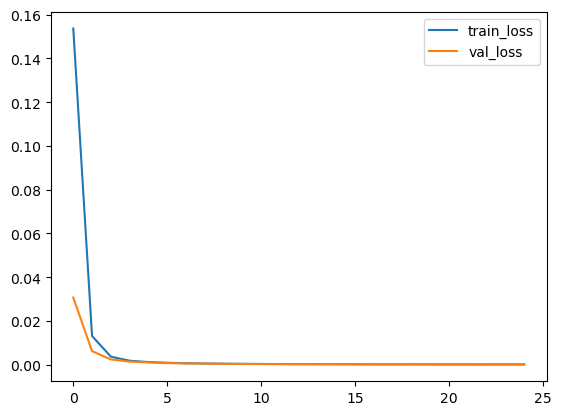

In [93]:
plt.plot(train_losses, label = 'train_loss')
plt.plot(val_losses, label = 'val_loss')
plt.legend()